# Data Exploratory Analisis

### Importar librerias

In [25]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.colors as col
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import missingno as msno
import openpyxl

Se descarga la data del indice SP500 de los ultimos 23 años.Utilizando unicamente el precio de cierre ajustado que ofrece suficiente información sobre el movimiento

In [2]:
start = dt.datetime(2000,1,1)
end = dt.datetime.now()   

sp500_data = yf.download('^GSPC', start=start, end= end)['Adj Close']

[*********************100%***********************]  1 of 1 completed


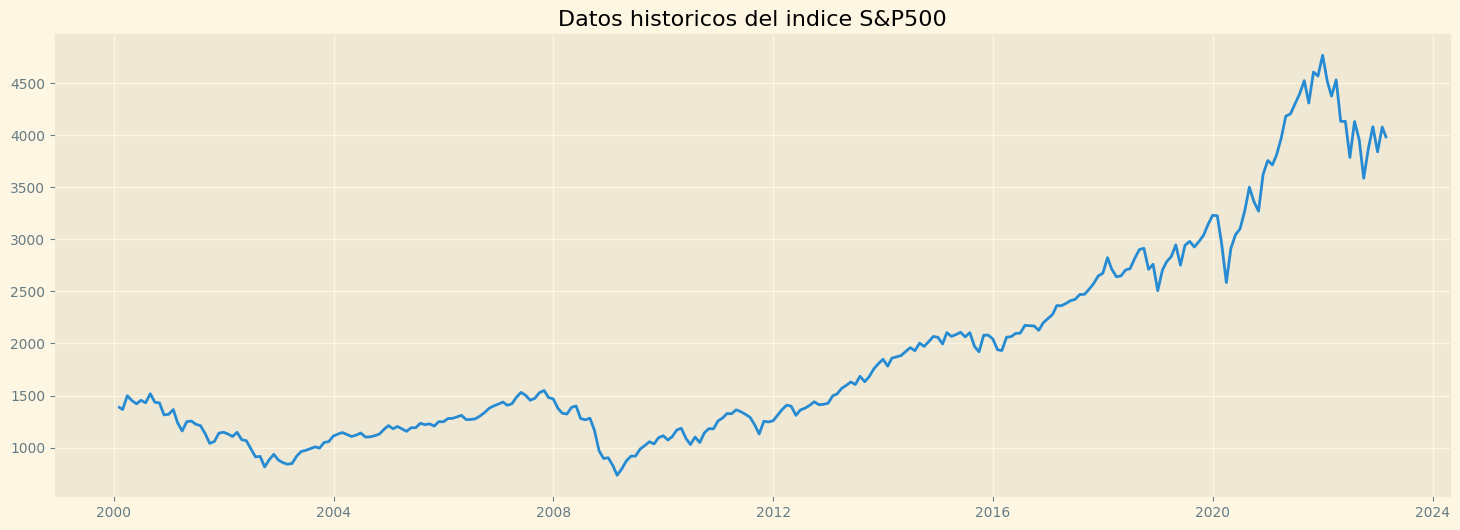

In [3]:
plt.style.use('Solarize_Light2')

sp500m = sp500_data.resample('M').apply(lambda x: x.iloc[-1,])

fig ,ax=  plt.subplots(figsize=(18,6))
line, = ax.plot(sp500m)
plt.title('Datos historicos del indice S&P500')

#ax.annotate('Burbuja tecnologica',xy=(mdates.date2num(max_2000),1500),xytext=(3,1.5),xycoords='axes fraction',
#             arrowprops=dict(facecolor='black',shrink=0.05),horizontalalignment='left')

plt.show()

En el grafico del historico de precios se observa que la tendencia general es al alza, pero vamos a verlo mas en profundidad

In [94]:
sp500_data.describe()

count    5824.000000
mean     1887.428640
std       977.504549
min       676.530029
25%      1184.485016
50%      1434.540039
75%      2390.967407
max      4796.560059
Name: Adj Close, dtype: float64

<Figure size 1800x600 with 0 Axes>

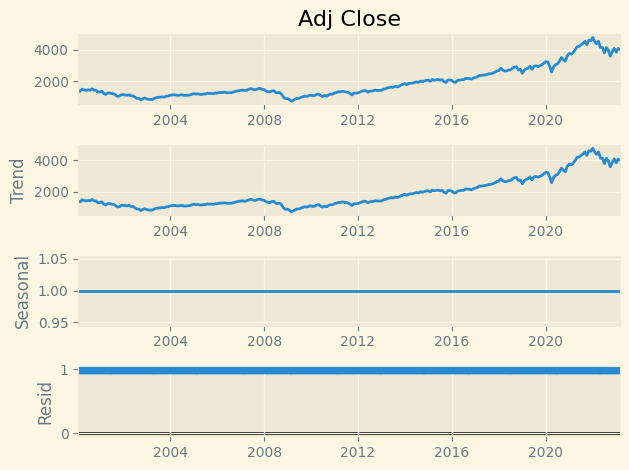

In [95]:
descomposicion = seasonal_decompose(sp500m, model='multiplicative', period=1)
fig = plt.figure(figsize=(18,6))
descomposicion.plot()
plt.show()

El precio de por si no muestra mucha información, mas que su tendencia general. Por eso analizamos las variaciones en el precio, conocidas en finanzas como rentabilidad o rendimientos. En este caso con frecuencia mensual.

Para el cálculo de la variaciones utilizamos el rendimiento logaritmico, ya que se trata de una variable continua. Mas información en este [articulo](https://quantdare.com/por-que-usar-rendimientos-logaritmicos/)

In [4]:
sp500_var = np.log1p(sp500m.pct_change())

In [5]:
sp500_var.describe()

count    277.000000
mean       0.003777
std        0.045061
min       -0.185636
25%       -0.018426
50%        0.009931
75%        0.031457
max        0.119421
Name: Adj Close, dtype: float64

La desviación estarndar nos muestra la volatilidad mensual del indice que es de 4.5% y una rentabilidad mensual promedio de 0.4%

<Figure size 1800x600 with 0 Axes>

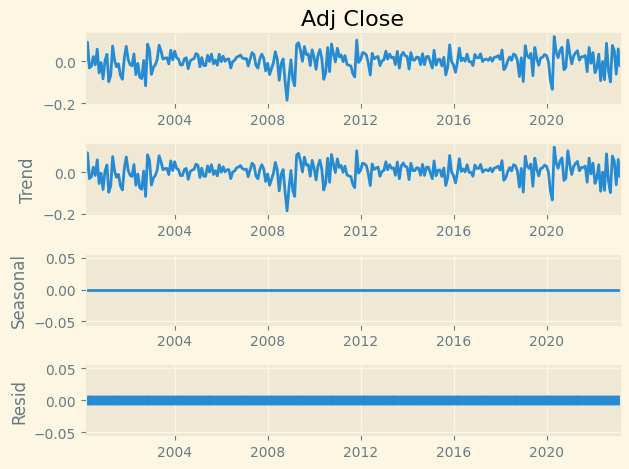

In [6]:
descomposicion = seasonal_decompose(sp500_var.dropna(), model='additive', period=1)
fig = plt.figure(figsize=(18,6))
descomposicion.plot()
plt.show()

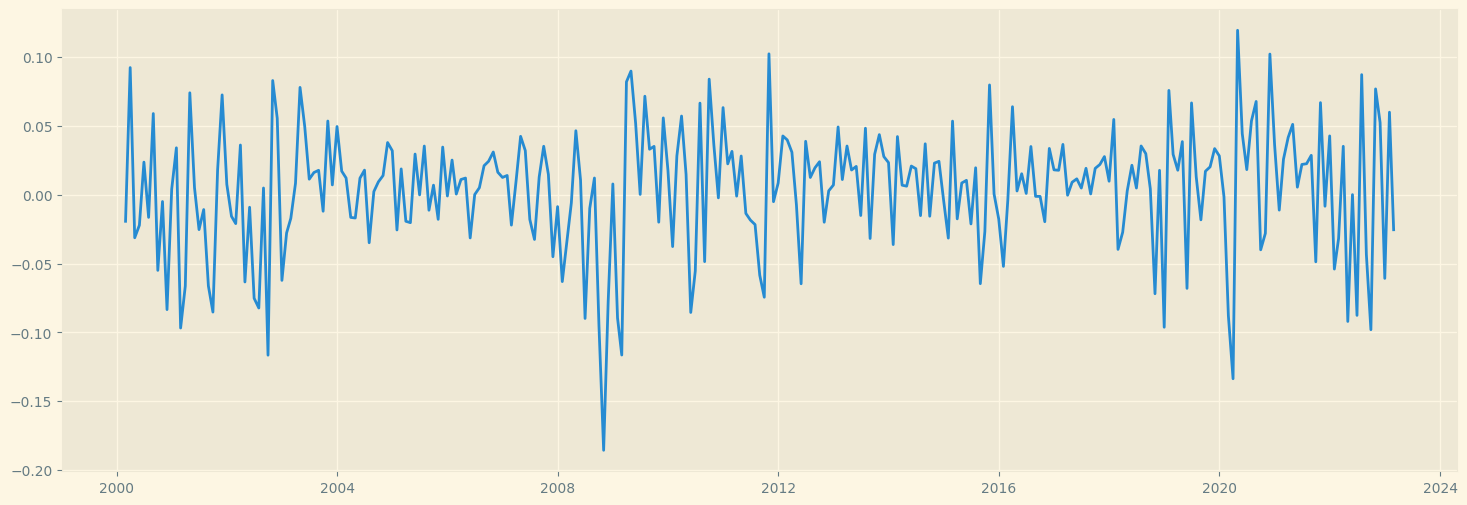

In [7]:
fig = plt.figure(figsize=(18,6))
plt.plot(sp500_var)
plt.show()

Esta información nos revela algunos puntos interesantes, que vamos analizar con su distribución

<AxesSubplot: >

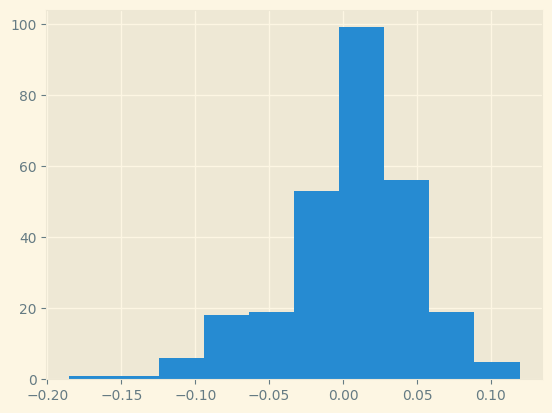

In [9]:
#Histograma de sp500_var
sp500_var.hist()

In [10]:
sp500_var[sp500_var < -0.10]

Date
2002-09-30   -0.116561
2008-10-31   -0.185636
2009-02-28   -0.116457
2020-03-31   -0.133668
Name: Adj Close, dtype: float64

En el histograma se pueden ver algunos outliers en la información que si comparamos con la historia economica, se refieren a crisis o cisnes negros como:
- 2002 Burbuja de empresas tecnologicas
- 2008 Crisis inmobiliaria en Estados Unidos
- 2020 Pandemia Covid-19

In [11]:
#grafico heatmap, mes a mes, año a año
performance = pd.DataFrame(sp500_var.copy())
performance['Mes'] = performance.index.month
performance['Año'] = sp500_var.index.year
performance.head()

,Adj Close,Mes,Año
Date,,,
2000-01-31,NaN,1,2000
2000-02-29,-0.020313,2,2000
2000-03-31,0.092324,3,2000
2000-04-30,-0.031280,4,2000
2000-05-31,-0.022159,5,2000


In [12]:
performance = performance.pivot(index='Mes',columns='Año',values='Adj Close')
meses = {1:'Enero',2:'Febrero',3:'Marzo',4:'Abril',5:'Mayo',6:'Junio',
         7:'Julio',8:'Agosto',9:'Septiembre',10:'Octubre',11:'Noviembre',12:'Diciembre'}
performance.rename(index=meses,inplace=True)

Text(0.5, 1.0, 'Rentabilidad del S&P500 los ultimos 23 años\n')

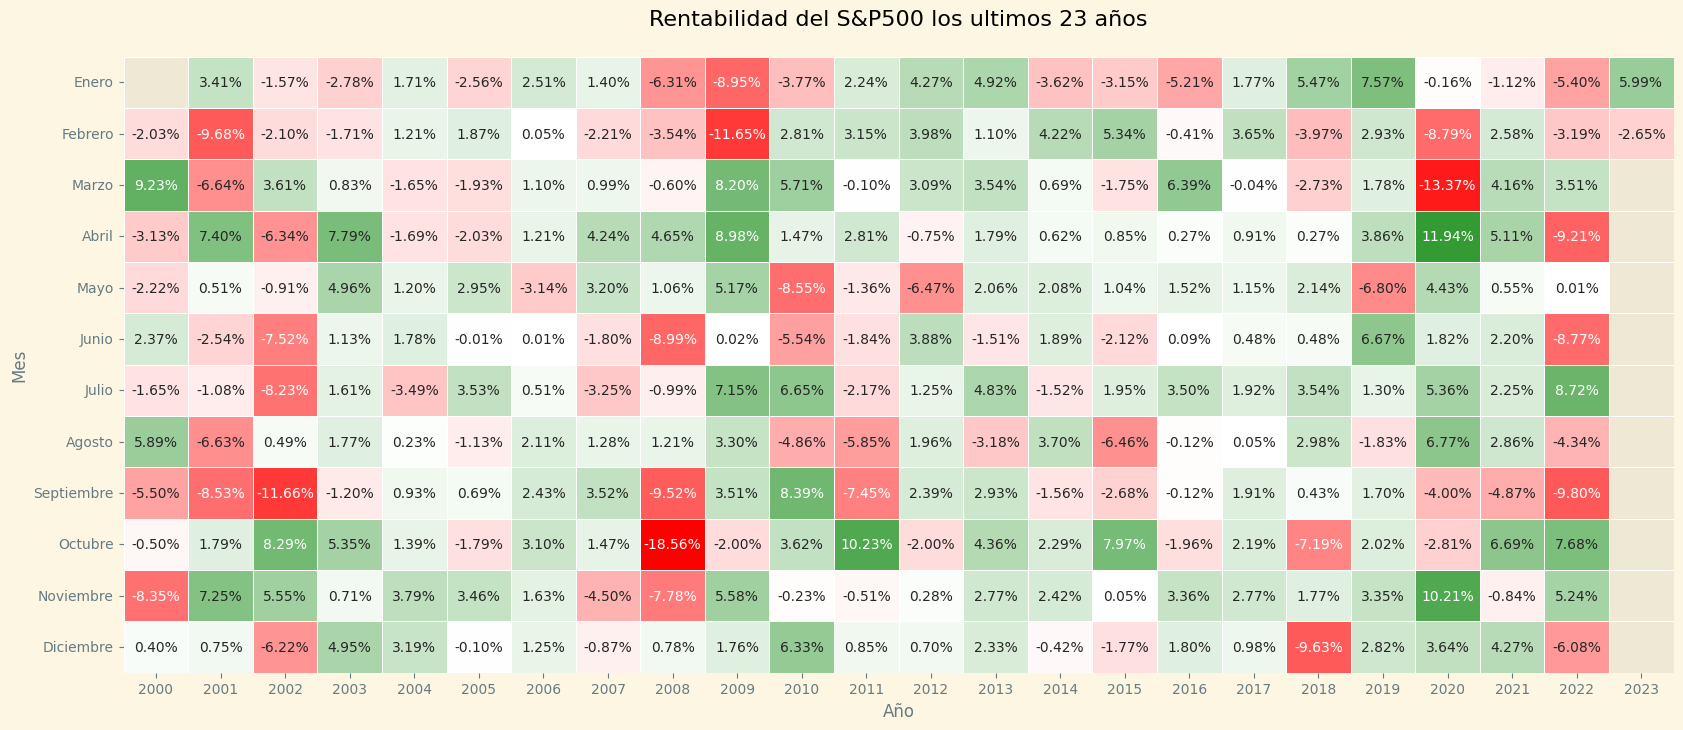

In [13]:
fig = plt.figure(figsize=(20,8))
cmap = col.LinearSegmentedColormap.from_list("red_green", ["red",'white',"green"],N=256)
sns.heatmap(performance,annot=True,fmt='.2%',linewidths=.5,cbar= False,cmap=cmap,vmax=0.15,vmin=-0.15)
plt.title('Rentabilidad del S&P500 los ultimos 23 años\n')

Con este mapa de calor se ve mas de cerca los momentos de crisis,como que en septiembre de 2008 estallo la burbuja inmobiliaria en Estados Unidos y que en marzo de 2020 se declaro el el virus del covid-19 como Pandemia

In [14]:
sp500y = sp500_data.resample('Y').apply(lambda x: x.iloc[-1,])
sp500y_var = np.log1p(sp500y.pct_change())


In [15]:
sp500y_var.describe()

count    23.000000
mean      0.047868
std       0.183844
min      -0.485902
25%      -0.003662
50%       0.091074
75%       0.164063
max       0.259292
Name: Adj Close, dtype: float64

La volatilidad anual del SP500 es de 18% y una rentabilidad anual promedio de 5%. Tambien hay que tomar en cuenta que esta media puede ser mas alta ya que los datos estan sesgados

Tambien se puede ver que mas del 50% de los datos son positivos anualmente,lo que refuerza esa tendencia alcista generalizada

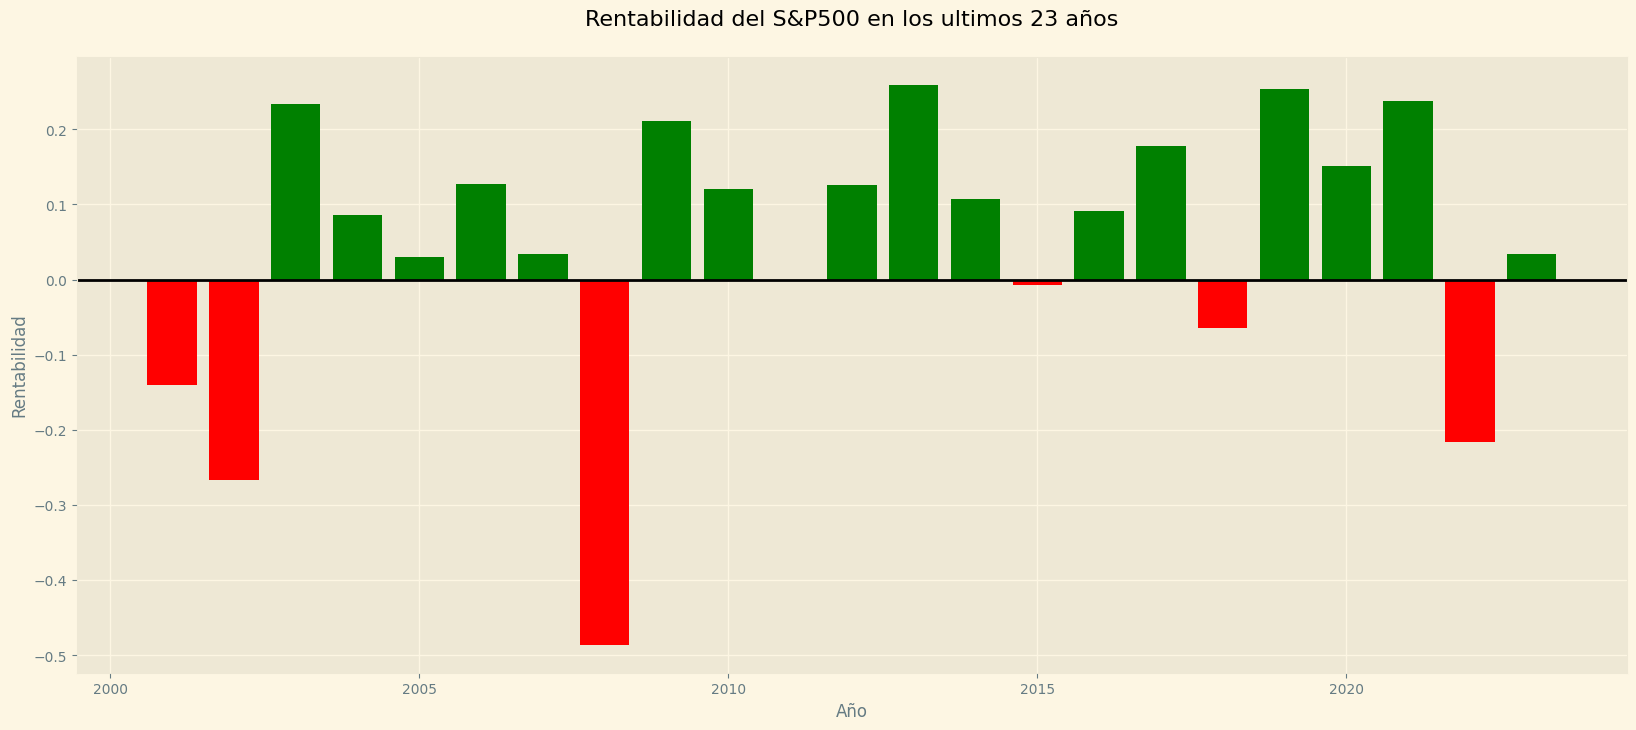

In [16]:
fig2 = plt.figure(figsize=(20,8))
profit_color = [('green' if p > 0 else 'red') for p in sp500y_var.values]
plt.bar(sp500y_var.index.year,sp500y_var.values ,color= profit_color)

plt.axhline(0, color="k")
plt.xlabel("Año")
plt.ylabel("Rentabilidad")
#plt.bar_label(barg,fmt='%.2f')
plt.title("Rentabilidad del S&P500 en los ultimos 23 años\n")
plt.show()

La mayotia del tiempo el indice va al alza, salvo en los momentos de crisis ya identificados

# Analisis sectorial y de los componentes del indice

In [19]:
componentes = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
componentes.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [20]:
componentes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Symbol                 503 non-null    object
 1   Security               503 non-null    object
 2   GICS Sector            503 non-null    object
 3   GICS Sub-Industry      503 non-null    object
 4   Headquarters Location  503 non-null    object
 5   Date added             499 non-null    object
 6   CIK                    503 non-null    int64 
 7   Founded                503 non-null    object
dtypes: int64(1), object(7)
memory usage: 31.6+ KB


El indice S&P500 contiente empresas pertenecientes a 11 sectores económicos los cuales son:

In [21]:
componentes['GICS Sector'].unique()

array(['Industrials', 'Health Care', 'Information Technology',
       'Communication Services', 'Consumer Staples',
       'Consumer Discretionary', 'Utilities', 'Financials', 'Materials',
       'Real Estate', 'Energy'], dtype=object)

El desempeño de cada sectores se puede observar con ayuda de los ETFs que contienen un portafolio con grupo de acciones ponderados por capitalización bursatil.

Los ETFs se encuentran en el link https://www.etf.com/sections/etf-strategist-corner/sector-sector-sp-500

In [22]:
etfs = ['XLI','XLV','XLK',
        'XLC','XLP',
        'XLY','XLU','XLF','XLB',
        'XLRE','XLE']

etf_sect = pd.DataFrame({'Sector':componentes['GICS Sector'].unique(),
                          'ETF': etfs})
etf_sect

,Sector,ETF
0,Industrials,XLI
1,Health Care,XLV
2,Information Technology,XLK
3,Communication Services,XLC
4,Consumer Staples,XLP
5,Consumer Discretionary,XLY
6,Utilities,XLU
7,Financials,XLF
8,Materials,XLB
9,Real Estate,XLRE


In [23]:
start = '2018-01-01'
sectores = yf.download(list(etf_sect.ETF.values),start,end)['Adj Close']
sectores
#print(((dfset['Close'].pct_change(axis=0)+1).cumprod()-1).iloc[-1])

[*********************100%***********************]  11 of 11 completed


,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
Date,,,,,,,,,,,
2018-01-02,55.380772,NaN,57.370697,25.193251,69.570847,61.131180,49.406284,27.734425,44.464108,76.747284,95.132996
2018-01-03,55.768688,NaN,58.229900,25.328604,69.945572,61.641079,49.388817,27.742889,44.114799,77.481613,95.569748
2018-01-04,56.255821,NaN,58.581398,25.563210,70.457390,61.952682,49.528618,27.268656,43.748463,77.591774,95.883087
2018-01-05,56.706879,NaN,58.557953,25.635393,70.941795,62.604233,49.747082,27.327936,43.731426,78.252663,96.642738
2018-01-08,56.788071,NaN,58.909451,25.599306,71.234276,62.840298,49.869419,27.514238,44.140366,77.968117,96.756676
...,...,...,...,...,...,...,...,...,...,...,...
2023-02-22,80.559998,54.240002,83.510002,35.599998,100.419998,136.300003,73.290001,38.480000,66.940002,129.839996,146.279999
2023-02-23,80.650002,53.990002,84.769997,35.630001,100.889999,138.559998,73.199997,38.849998,66.589996,130.190002,146.160004
2023-02-24,81.190002,53.240002,84.660004,35.660000,100.309998,136.089996,72.709999,38.130001,66.610001,128.509995,143.860001


<AxesSubplot: >

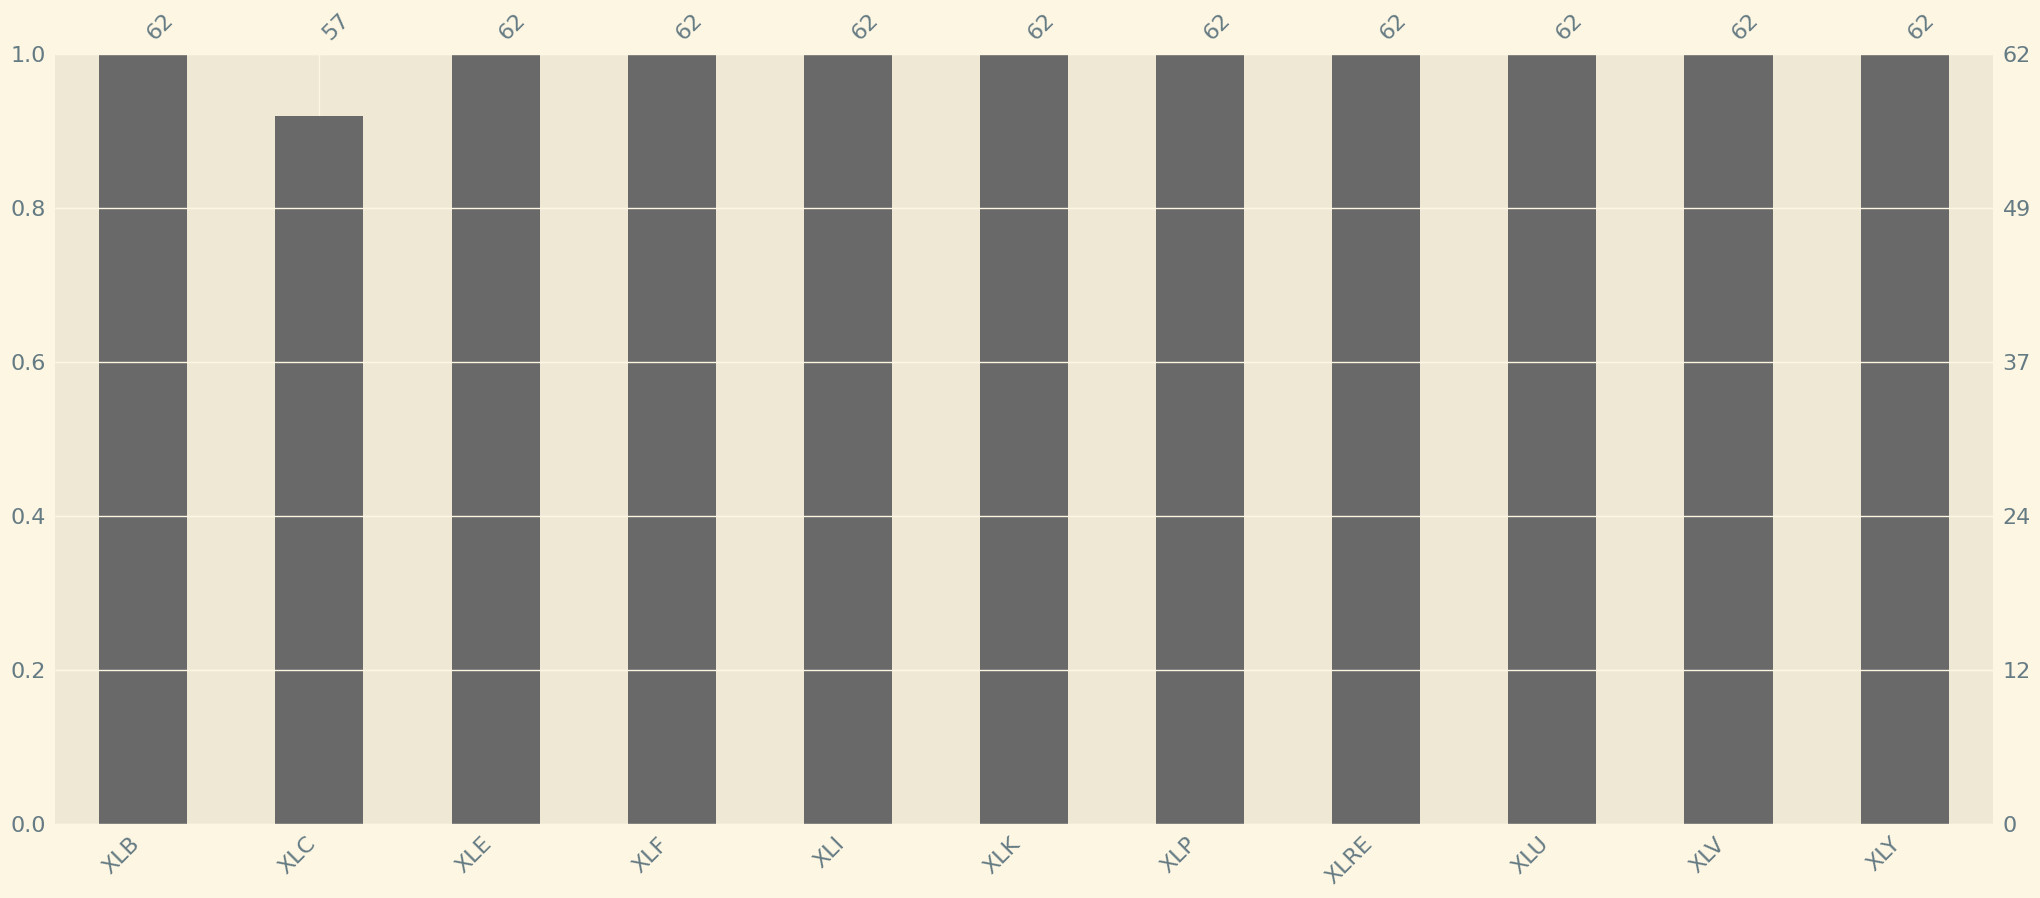

In [26]:
msno.bar(sectores)

In [24]:
sectores = sectores.resample('M').apply(lambda x: x.iloc[-1,])

In [27]:
sectores['SP500'] = sp500m[start:end]

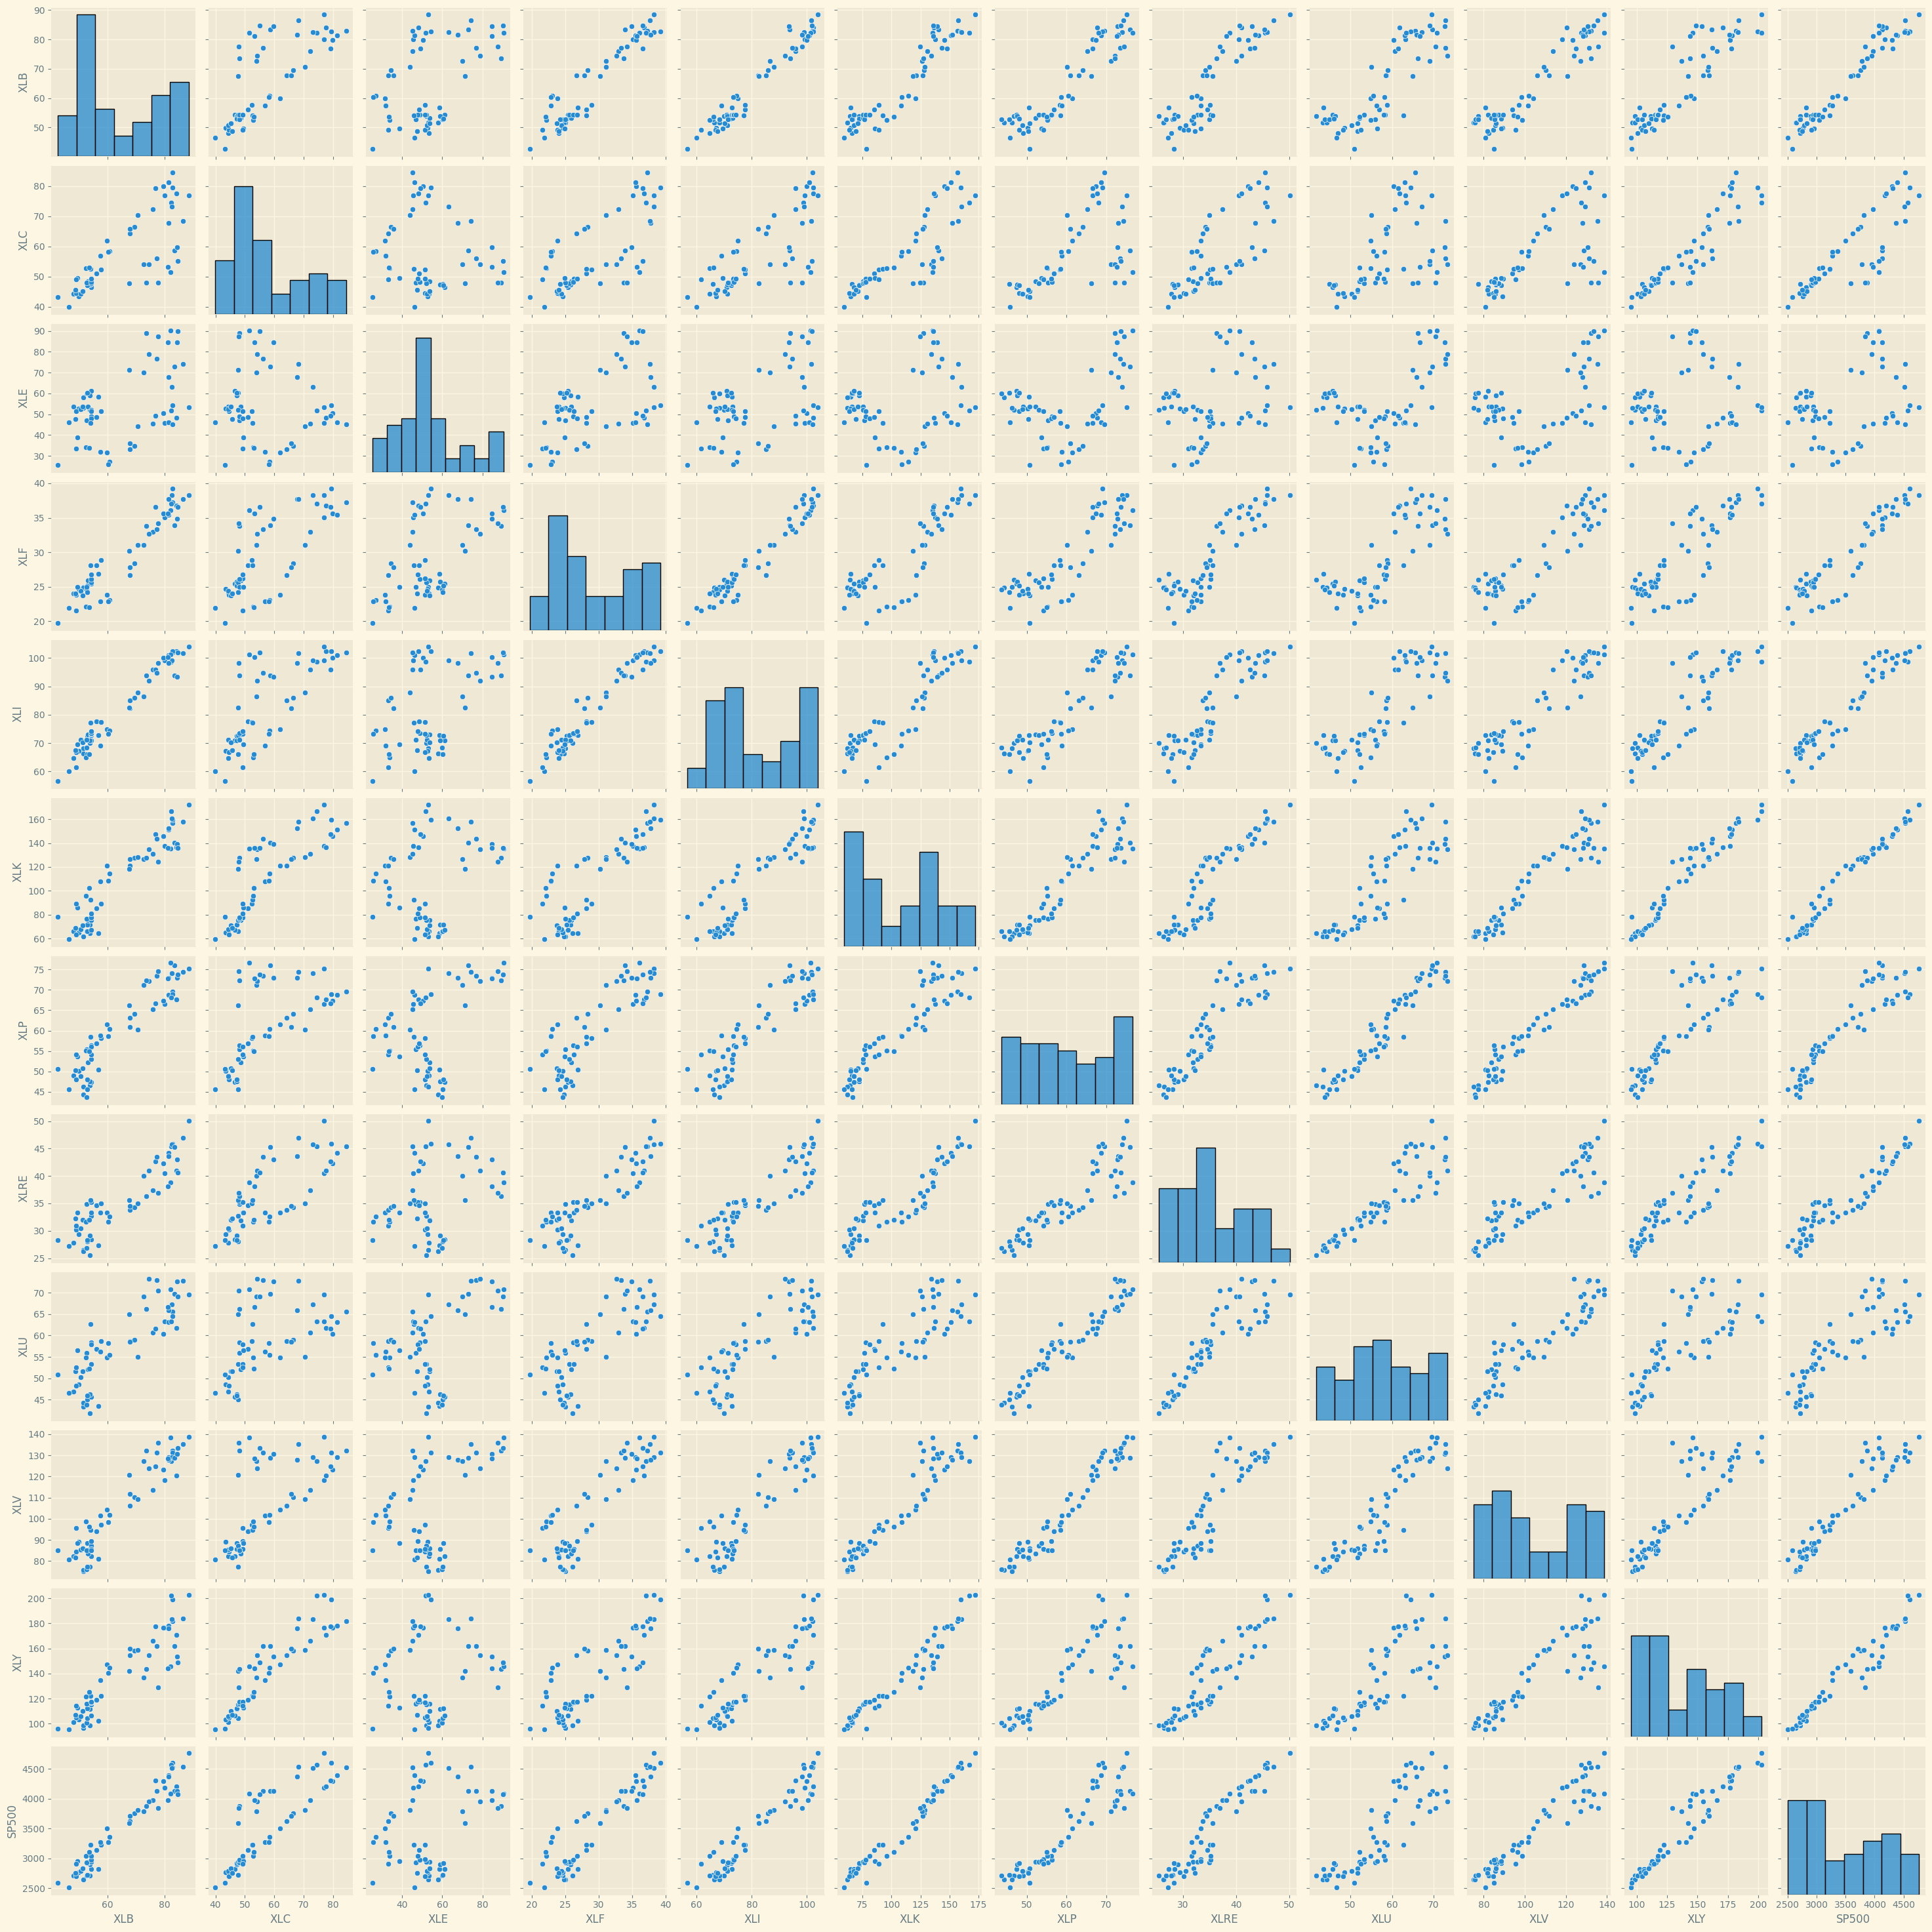

In [18]:
sns.pairplot(sectores)

Los sectores en su mayoria estan correlacionados

<AxesSubplot: >

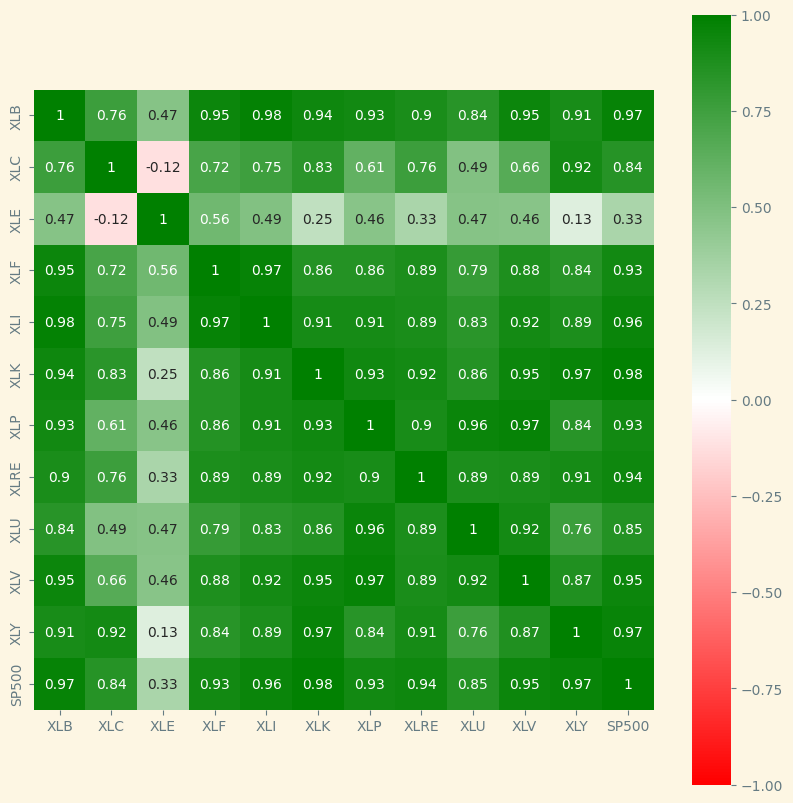

In [19]:
plt.figure(figsize=(10,10))
sns.heatmap(sectores.corr(),annot=True,square=True,cmap=cmap,vmin=-1,vmax=1)

Unicamente el sector de Energia tiene una correlación baja conrespecto a los demas sectores. En las inversiones se recomienda baja correlación para diversificar.

Vamos a graficar el movimiento de cadas sector contra el SP500 para ver mejor esa correlación

In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [29]:
scaled = scaler.fit_transform(sectores)
scaled = pd.DataFrame(scaled, columns=sectores.columns,index=sectores.index)


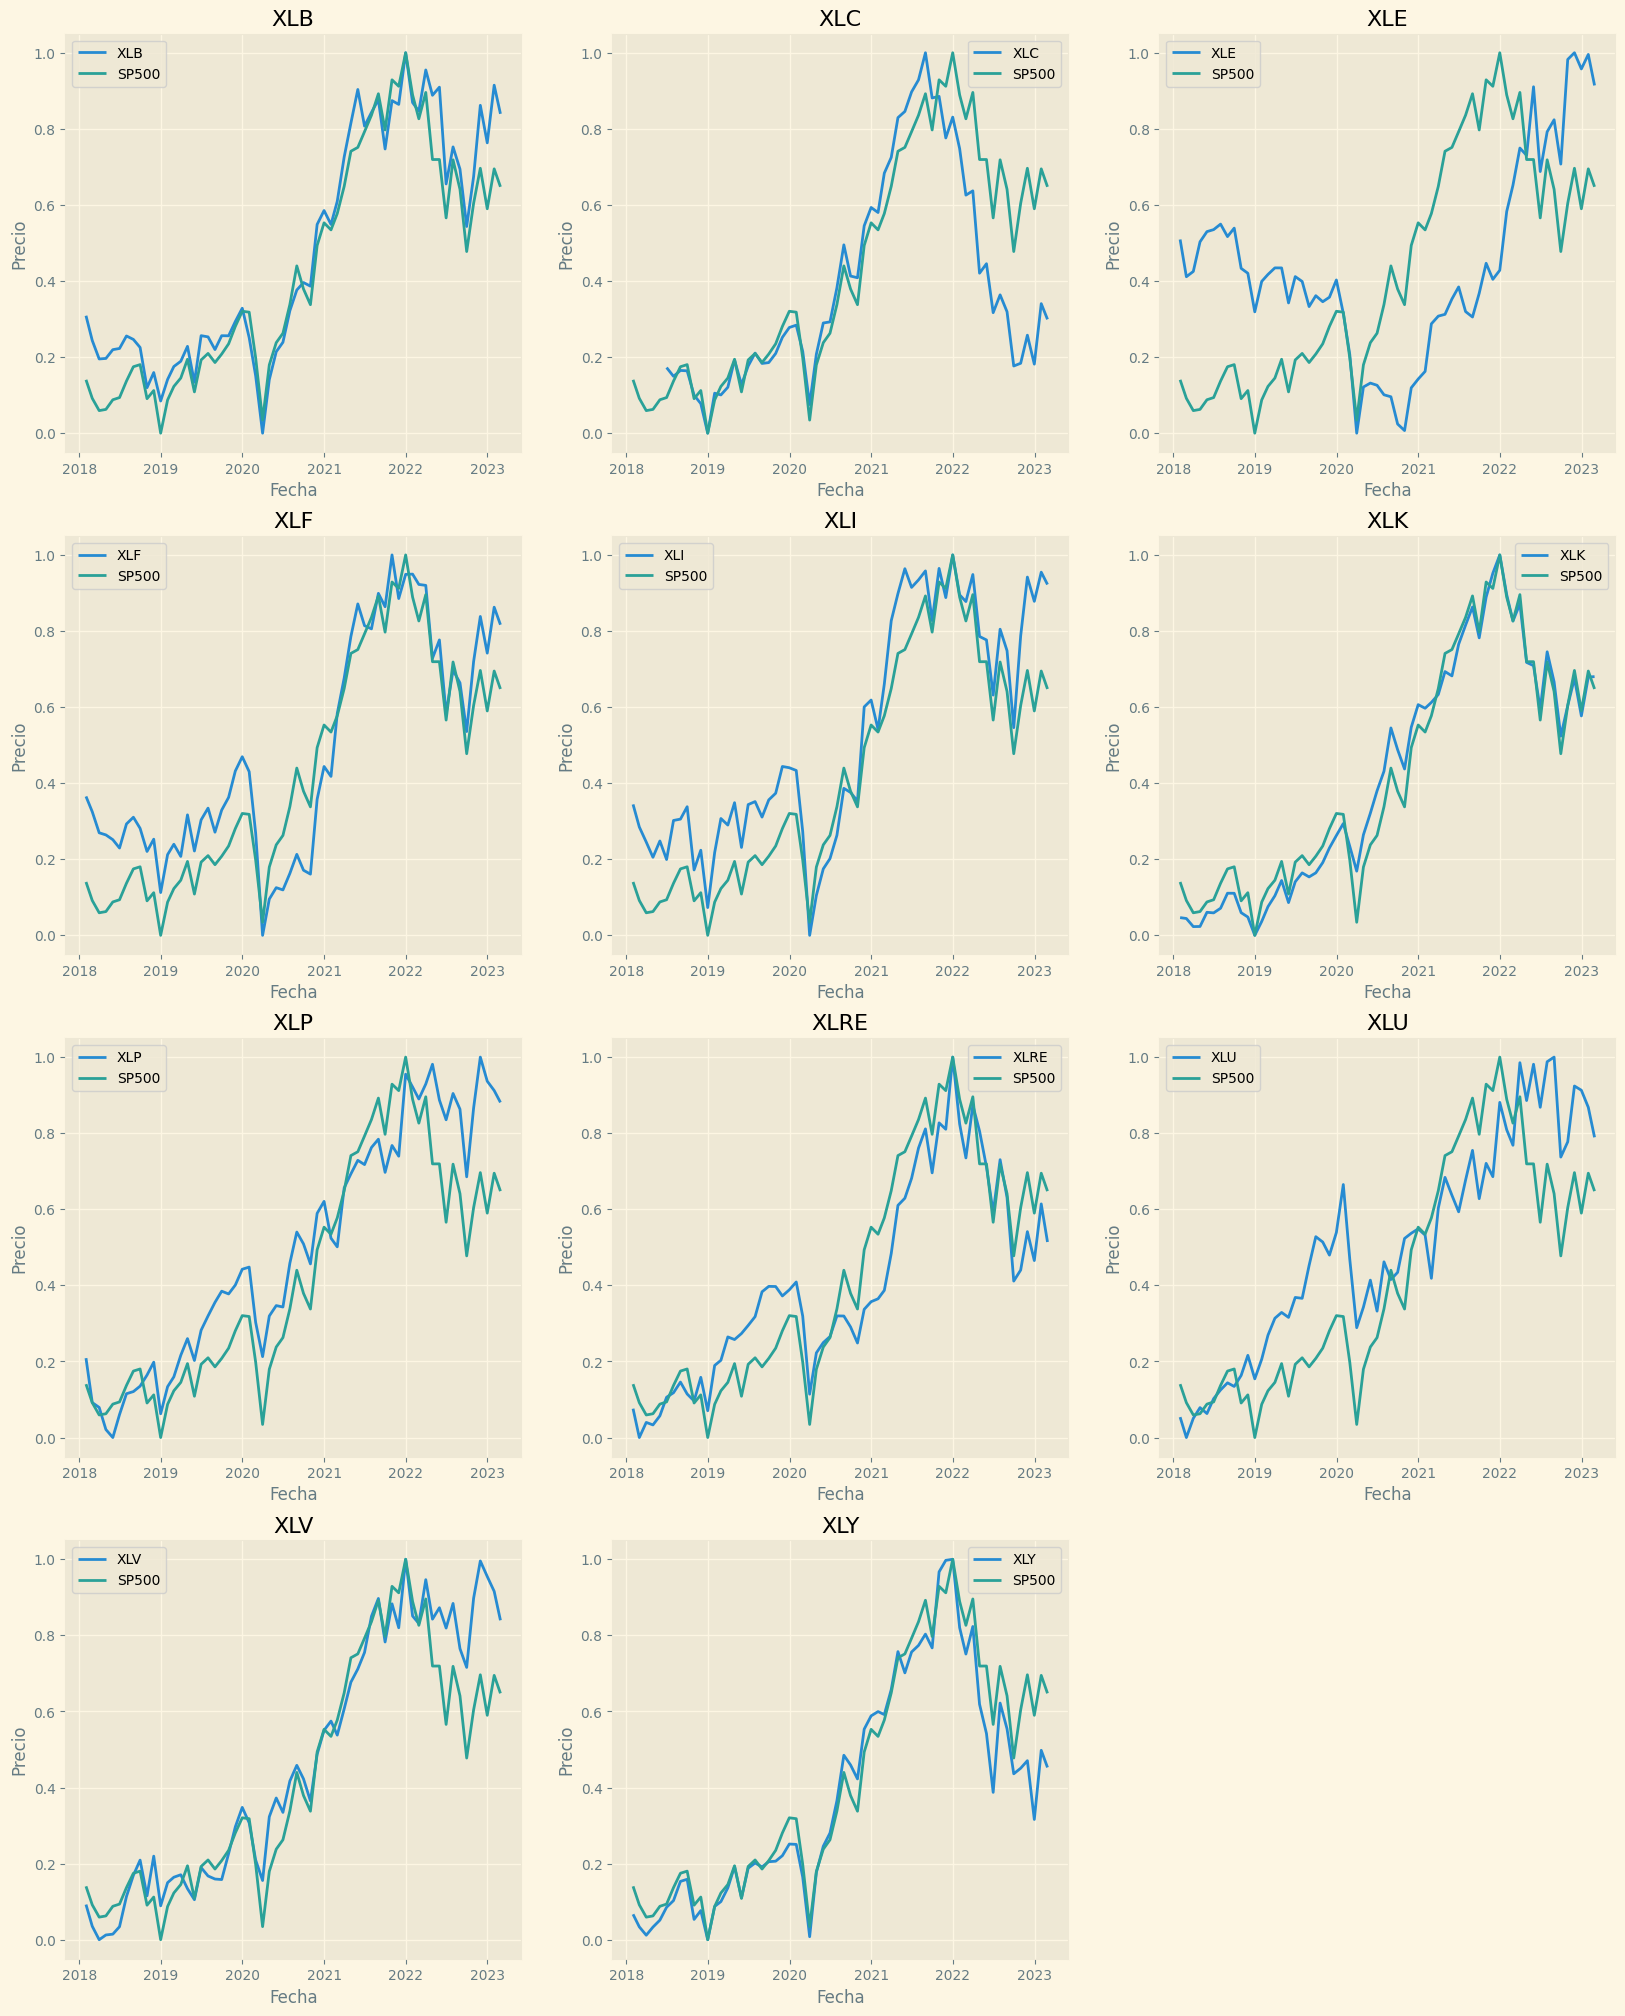

In [94]:
#grafico de cada sector contra el sp500
plt.figure(figsize = (20,25))


for i in range(11):

    plt.subplot(4,3,i+1)
    plt.title(scaled.iloc[:,i].name)
    plt.plot(scaled.iloc[:,i],label=scaled.iloc[:,i].name)
    plt.plot(scaled.iloc[:,-1],label='SP500')
    plt.xlabel('Fecha')
    plt.ylabel('Precio')
    plt.legend()

plt.show()   

Los graficos hablan por si solos

In [30]:
sectores_rent = np.log1p(sectores.pct_change())

In [31]:
sectores_rent.describe()

,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY,SP500
count,61.000000,56.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,0.005989,0.002091,0.005880,0.004688,0.005347,0.012258,0.005813,0.005475,0.006590,0.007421,0.005768,0.005586
std,0.063173,0.063296,0.110884,0.066430,0.065162,0.064131,0.042296,0.056334,0.047346,0.046276,0.068645,0.053994
min,-0.150785,-0.152359,-0.421152,-0.236177,-0.206114,-0.127460,-0.093372,-0.163774,-0.119696,-0.098204,-0.161500,-0.133668
25%,-0.035434,-0.039258,-0.041936,-0.027002,-0.028745,-0.038053,-0.016890,-0.026817,-0.020203,-0.026427,-0.027662,-0.028056
50%,0.014964,0.007004,0.015918,0.000256,0.009331,0.031957,0.013641,0.012138,0.010755,0.010750,0.012671,0.017766
75%,0.049570,0.037698,0.055526,0.049882,0.043981,0.061705,0.028117,0.043649,0.040267,0.042382,0.035901,0.038560
max,0.141382,0.137794,0.268223,0.155706,0.148656,0.128714,0.099435,0.102032,0.100316,0.118561,0.172966,0.119421


Vemos que la rentabilidad promedio de los sectores y del indice es similar,pero la volatilidad(desviacion estandar) varia mucho mas entre sectores. 

Se calcula el ratio de Sharpe, que nos da una relacion entre la rentabilidad y volatilidad para ubicar sectores con mejor desempeño que el indice SP500

NOTA. Para este calculo no utilizaremos la tasa libre de riesgo Rf, ya que solo disminuye el valor del ratio pero no tiene ningun efecto en terminos comparativos

In [32]:
comparacion = etf_sect.copy()
comparacion = comparacion.append({'Sector':'SP500','ETF':'SPY'},ignore_index=True)
# Para ver mejor la información, anualizamos la rentabilidad usando la formula de matematicas financieras ((1+i)^t)-1
comparacion['Rentabilidad'] = ((1+sectores_rent.mean().values)**12)-1 
#Igual para la volatilidad con la formula sigma*raiz(t)
comparacion['Volatilidad'] = sectores_rent.std().values*np.sqrt(12)
comparacion['Sharpe'] = comparacion.Rentabilidad/comparacion.Volatilidad
comparacion.sort_values(['Sharpe'],ascending=False)

/tmp/ipykernel_38618/810768303.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparacion = comparacion.append({'Sector':'SP500','ETF':'SPY'},ignore_index=True)


,Sector,ETF,Rentabilidad,Volatilidad,Sharpe
5,Consumer Discretionary,XLY,0.157427,0.222157,0.708628
9,Real Estate,XLRE,0.092782,0.160306,0.578778
8,Materials,XLB,0.082009,0.164011,0.500022
6,Utilities,XLU,0.072035,0.146518,0.491648
11,SP500,SPY,0.069124,0.187041,0.369566
7,Financials,XLF,0.067710,0.195148,0.346966
0,Industrials,XLI,0.074281,0.218838,0.339432
10,Energy,XLE,0.071460,0.237793,0.300513
4,Consumer Staples,XLP,0.066080,0.225726,0.292744
3,Communication Services,XLC,0.057733,0.230119,0.250883


De acuerdo a la información se eligen los sectores con ratio Sharpe superior al del indice,agregando el sector de Energia por tener la correlacion mas baja de todos con respecto al indice y buscando disversificar

In [33]:
gics = list(comparacion.sort_values(['Sharpe'],ascending=False)['Sector'].head(4).values)
gics.append('Energy')
gics

['Consumer Discretionary', 'Real Estate', 'Materials', 'Utilities', 'Energy']

In [34]:


universo = componentes[componentes['GICS Sector'].isin(gics)][['Symbol','GICS Sector']]
universo.groupby(['GICS Sector']).count()

,Symbol
GICS Sector,
Consumer Discretionary,56
Energy,23
Materials,29
Real Estate,30
Utilities,30


In [35]:
universo.shape

(168, 2)

Eligiendo solo estos sectores,tenemos un universo de inversión de 168 para analizar y elegir algunas finalistas.

Utilizando informacion historica de los ultimos 5 años. Que es suficiente, ya que captura la ultima crisis del covid19 y algunos años en condiciones normales

# Universo de inversión

In [36]:
universo_data = yf.download(list(universo.Symbol.values),start,end)['Adj Close']

[*********************100%***********************]  168 of 168 completed


<AxesSubplot: >

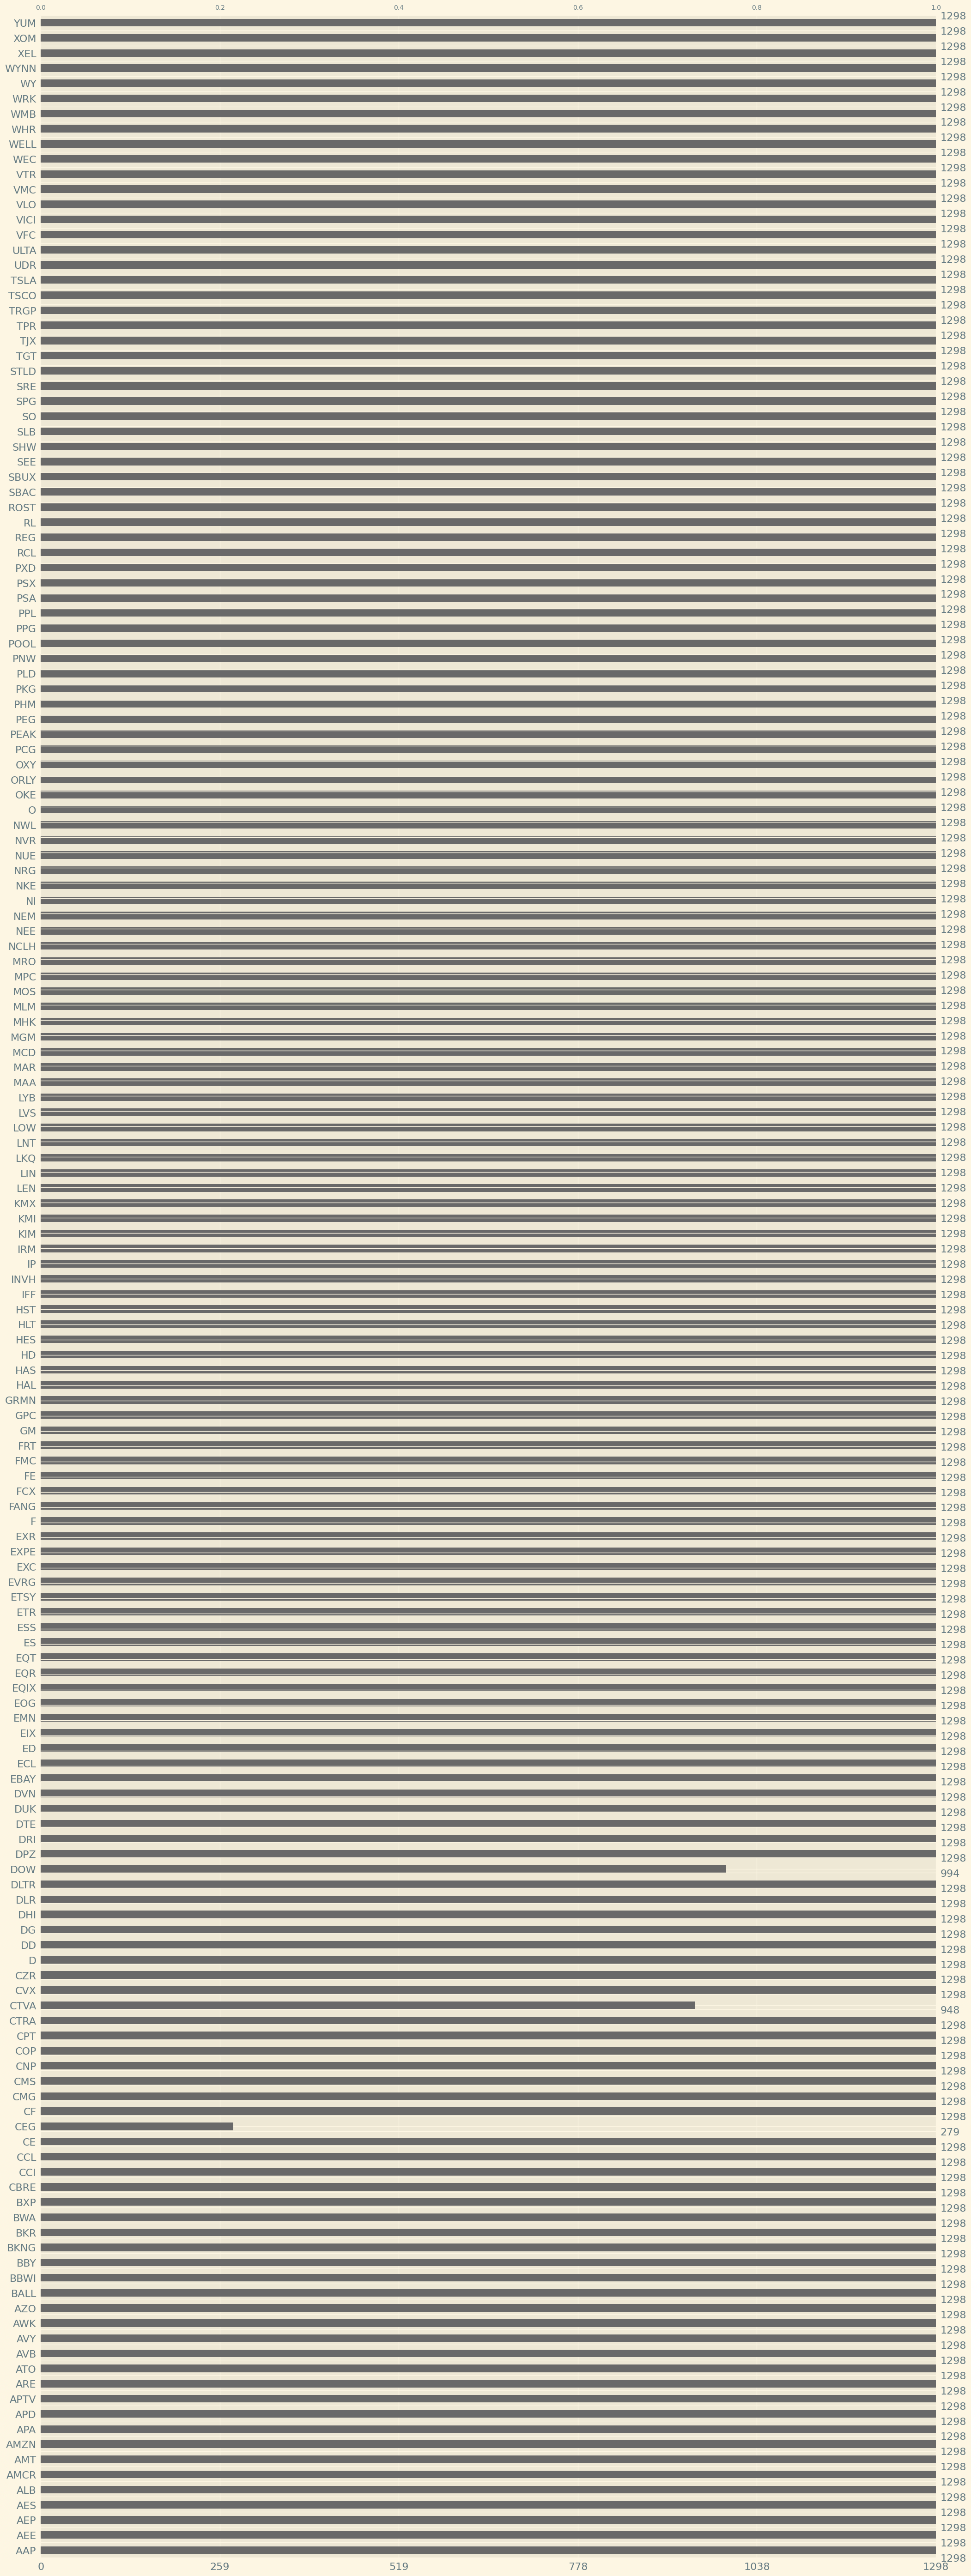

In [37]:
msno.bar(universo_data)

In [38]:
universo_data.drop(columns=['CEG'],inplace=True)  #Solo se elimina esta accion ya que poses poco mas de un año de data. Cada año tiene 252 dias bursatiles
universo_data.index = pd.to_datetime(universo_data.index)

In [40]:
universo_data = universo_data.resample('M').apply(lambda x: x.iloc[-1,])
universo_rent = np.log1p(universo_data.pct_change())

In [50]:
#crear tabla symbol,rentabilidad,volatilidad,sharpe
acciones = pd.DataFrame({'Symbol':universo_data.columns,
                        'Rentabilidad':((1+universo_rent.mean().values)**12)-1,
                        'Volatilidad':universo_rent.std().values*np.sqrt(12)})

acciones['Sharpe'] = acciones.Rentabilidad/acciones.Volatilidad
acciones.sort_values(['Sharpe'],ascending=False)

,Symbol,Rentabilidad,Volatilidad,Sharpe
35,CTVA,0.264849,0.254230,1.041769
16,AZO,0.258054,0.248043,1.040362
148,TSCO,0.261677,0.257958,1.014415
29,CMG,0.344674,0.342318,1.006883
116,ORLY,0.249532,0.250692,0.995374
...,...,...,...,...
161,WRK,-0.110216,0.350659,-0.314310
105,NCLH,-0.244790,0.771234,-0.317400
100,MHK,-0.180787,0.432043,-0.418446
26,CCL,-0.305540,0.667174,-0.457960


In [48]:
#Elijo el top 10p por ratio de Sharpe
top10 = acciones.sort_values(['Sharpe'],ascending=False).head(10)
top10 = pd.merge(top10,universo,on='Symbol',how='inner')
top10

,Symbol,Rentabilidad,Volatilidad,Sharpe,GICS Sector
0,CTVA,0.264849,0.254230,1.041769,Materials
1,AZO,0.258054,0.248043,1.040362,Consumer Discretionary
2,TSCO,0.261677,0.257958,1.014415,Consumer Discretionary
3,CMG,0.344674,0.342318,1.006883,Consumer Discretionary
4,ORLY,0.249532,0.250692,0.995374,Consumer Discretionary
5,LIN,0.181866,0.220691,0.824077,Materials
6,DG,0.166000,0.207982,0.798149,Consumer Discretionary
7,POOL,0.219926,0.288769,0.761600,Consumer Discretionary
8,TSLA,0.519518,0.688841,0.754192,Consumer Discretionary
9,EXR,0.179565,0.240802,0.745694,Real Estate


El top 10 no incluye acciones de lso 5 sectores selccionados, asi probamos con el top 2 de cada sector

In [51]:
acciones = pd.merge(acciones,universo,on='Symbol',how='inner')
acciones.rename(columns={'GICS Sector':'Sector'},inplace=True)
acciones.head()

,Symbol,Rentabilidad,Volatilidad,Sharpe,Sector
0,AAP,0.055697,0.347748,0.160165,Consumer Discretionary
1,AEE,0.105737,0.176408,0.599392,Utilities
2,AEP,0.086846,0.200584,0.432967,Utilities
3,AES,0.194957,0.304857,0.639503,Utilities
4,ALB,0.189699,0.466642,0.406520,Materials


In [53]:
symbols = []
for sector in acciones.Sector.unique():
    acciones_sector = acciones[acciones.Sector == sector]
    symbols.append(acciones_sector.sort_values(['Sharpe'],ascending=False).head(2)['Symbol'].values)
symbols =[i for sublist in symbols for i in sublist]
symbols

['AZO', 'TSCO', 'NEE', 'AES', 'CTVA', 'LIN', 'EXR', 'MAA', 'HES', 'COP']

In [59]:
top10 = acciones[acciones.Symbol.isin(symbols)]
top10.sort_values('Sharpe',ascending=False)

,Symbol,Rentabilidad,Volatilidad,Sharpe,Sector
35,CTVA,0.264849,0.254230,1.041769,Materials
16,AZO,0.258054,0.248043,1.040362,Consumer Discretionary
148,TSCO,0.261677,0.257958,1.014415,Consumer Discretionary
90,LIN,0.181866,0.220691,0.824077,Materials
66,EXR,0.179565,0.240802,0.745694,Real Estate
106,NEE,0.147235,0.217613,0.676593,Utilities
96,MAA,0.141277,0.219939,0.642347,Real Estate
3,AES,0.194957,0.304857,0.639503,Utilities
79,HES,0.230622,0.490572,0.470107,Energy
32,COP,0.153399,0.440033,0.348609,Energy


In [55]:
comparacion.iloc[-1,:]

Sector             SP500
ETF                  SPY
Rentabilidad    0.069124
Volatilidad     0.187041
Sharpe          0.369566
Name: 11, dtype: object

Al comparar el top10 de acciones, notamos que todas tienen mejor rentabilidad y ratio Sharpe

In [56]:
#Grafico acumulado
scaled10 = scaler.fit_transform(universo_data[top10.Symbol])
scaled10 = pd.DataFrame(scaled10, columns=top10.Symbol,index=universo_data.index)
scaled10

Symbol,AES,AZO,COP,CTVA,EXR,HES,LIN,MAA,NEE,TSCO
Date,,,,,,,,,,
2018-01-31,0.030473,0.072101,0.240455,NaN,0.000000,0.122846,0.069883,0.055053,0.020273,0.068941
2018-02-28,0.000000,0.020568,0.204099,NaN,0.008963,0.083222,0.019877,0.000000,0.000000,0.010194
2018-03-31,0.022082,0.012366,0.247360,NaN,0.026614,0.125729,0.000000,0.031244,0.044055,0.000000
2018-04-30,0.066273,0.000000,0.301305,NaN,0.039459,0.175574,0.035203,0.037840,0.046341,0.026579
2018-05-31,0.089037,0.012689,0.320139,NaN,0.077819,0.202413,0.051220,0.050068,0.053827,0.061920
...,...,...,...,...,...,...,...,...,...,...
2022-10-31,0.858750,0.976403,1.000000,0.955805,0.708084,0.919859,0.758238,0.558415,0.749740,0.911783
2022-11-30,1.000000,1.000000,0.978807,1.000000,0.596256,0.943734,0.939344,0.608113,0.882582,0.954452
2022-12-31,0.991812,0.942276,0.930628,0.811638,0.515440,0.929443,0.896940,0.555339,0.863334,0.946809


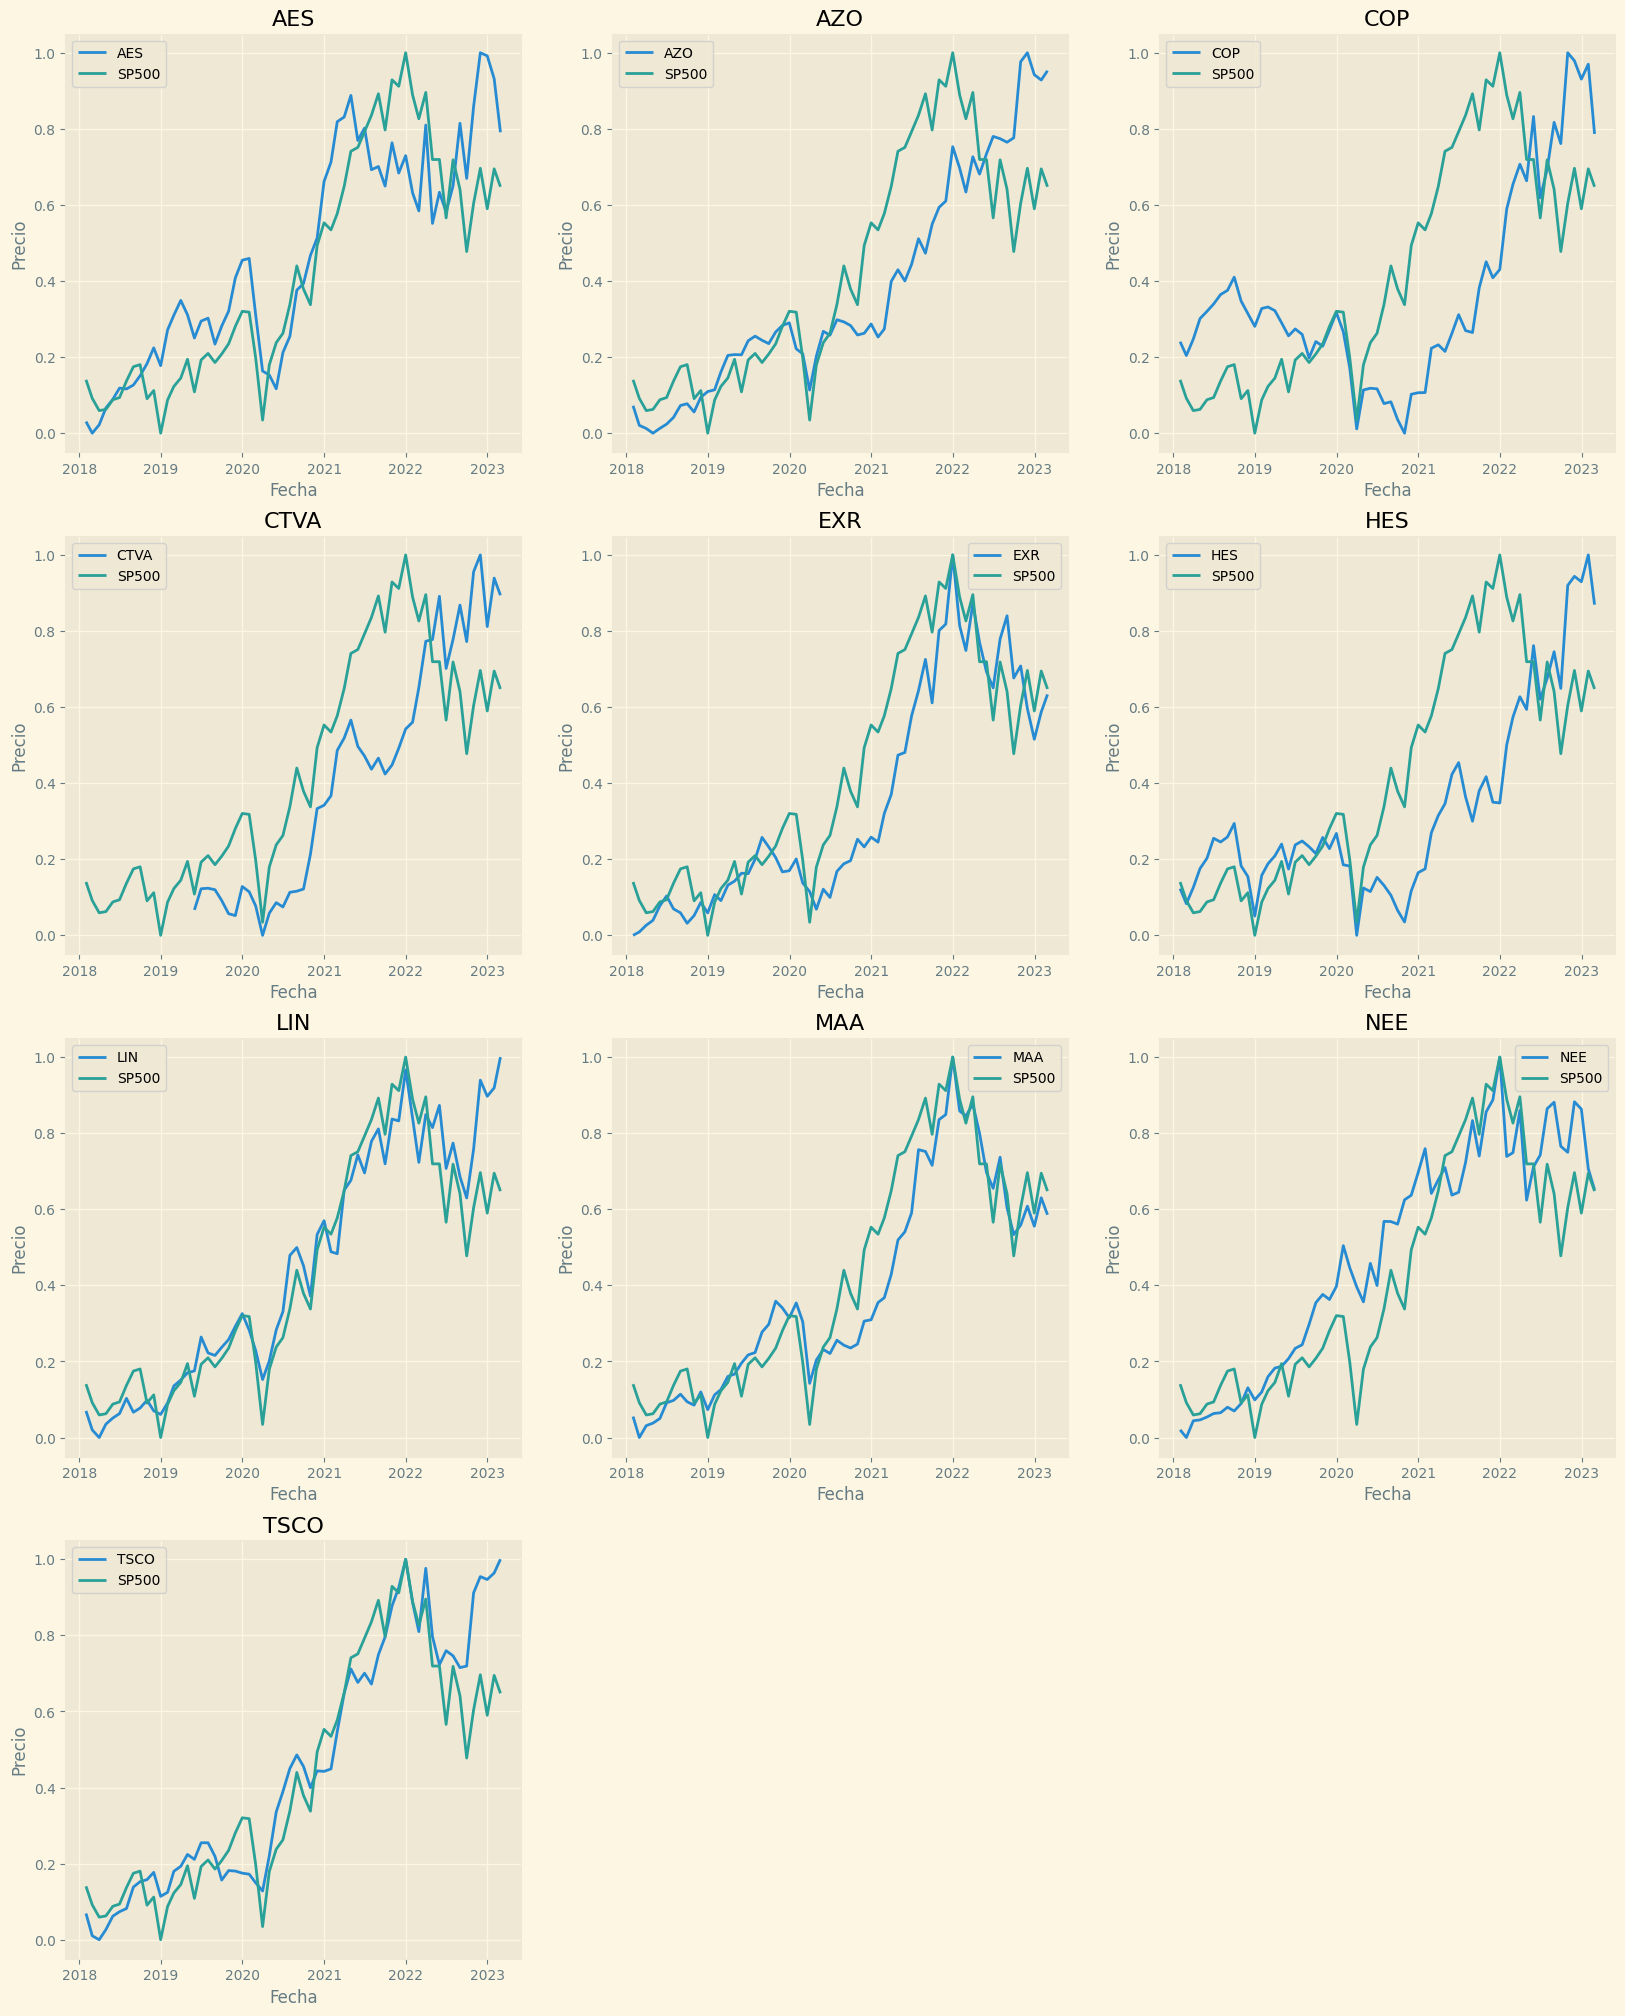

In [57]:
plt.figure(figsize = (20,25))

for i in range(10):

    plt.subplot(4,3,i+1)
    plt.title(scaled10.iloc[:,i].name)
    plt.plot(scaled10.iloc[:,i],label=scaled10.iloc[:,i].name)
    plt.plot(scaled.iloc[:,-1],label='SP500')
    plt.xlabel('Fecha')
    plt.ylabel('Precio')
    plt.legend()

plt.show()   

/tmp/ipykernel_38618/3264073803.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top10_data['SP500'] = sp500m[start:]


<AxesSubplot: >

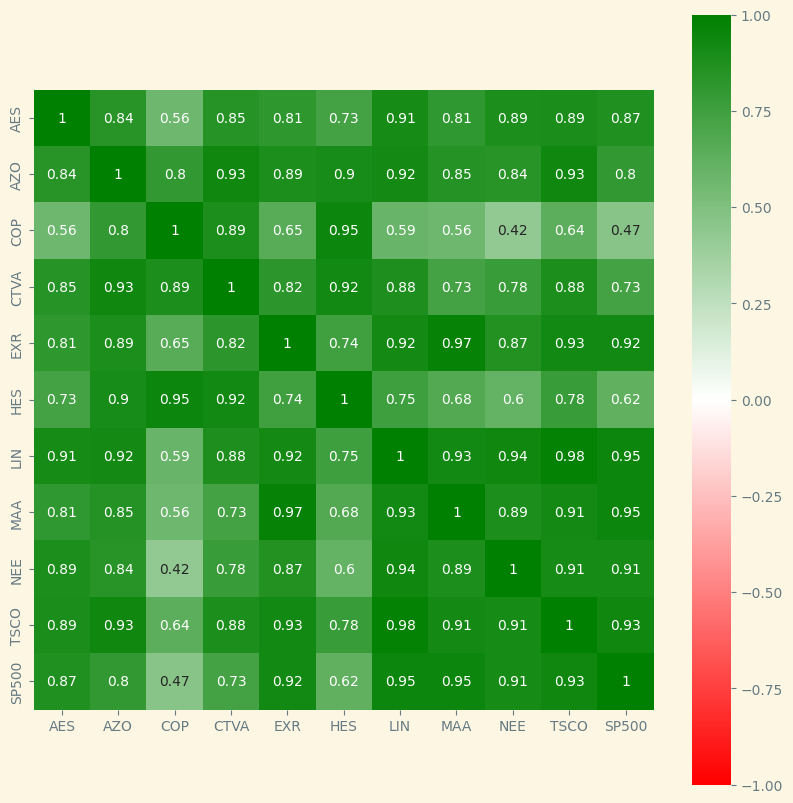

In [60]:
#Correlacion
top10_data = universo_data[top10.Symbol]
top10_data['SP500'] = sp500m[start:]

plt.figure(figsize=(10,10))
sns.heatmap(top10_data.corr(),annot=True,square=True,cmap=cmap,vmin=-1,vmax=1)

# Metricas Financieras

In [61]:
metricas =[]
for i in symbols:
    metricas.append(pd.read_excel('https://stockrow.com/api/companies/{}/financials.xlsx?dimension=Q&section=Metrics&sort=desc'.format(i)))


,Unnamed: 0,2022-11-30 00:00:00,2022-08-31 00:00:00,2022-05-31 00:00:00,2022-04-30 00:00:00,2022-02-28 00:00:00,2021-11-30 00:00:00,2021-08-31 00:00:00,2021-05-31 00:00:00,2021-04-30 00:00:00,...,2015-08-31 00:00:00,2015-05-31 00:00:00,2015-02-28 00:00:00,2014-11-30 00:00:00,2014-08-31 00:00:00,2014-05-31 00:00:00,2014-02-28 00:00:00,2013-11-30 00:00:00,2013-08-31 00:00:00,2013-05-31 00:00:00
0,P/E ratio,1.997060e+01,1.712220e+01,1.899870e+01,1.741920e+01,1.644360e+01,1.555710e+01,1.466720e+01,1.604150e+01,1.583350e+01,...,1.942990e+01,1.905920e+01,1.900320e+01,1.730450e+01,1.664270e+01,1.696230e+01,1.788840e+01,1.572430e+01,1.480110e+01,1.547430e+01
1,P/S ratio,2.872700e+00,2.590600e+00,2.761000e+00,2.537400e+00,2.449700e+00,2.400900e+00,2.277400e+00,2.317400e+00,2.258500e+00,...,2.218100e+00,2.142100e+00,2.115500e+00,1.918600e+00,1.883800e+00,1.846000e+00,1.930300e+00,1.694900e+00,1.649300e+00,1.665900e+00
2,P/FCF ratio,1.598330e+01,1.606870e+01,1.797840e+01,1.471280e+01,1.242920e+01,9.846500e+00,1.006160e+01,1.082160e+01,1.025770e+01,...,2.084220e+01,2.394940e+01,2.457850e+01,2.067060e+01,1.991700e+01,1.632200e+01,1.784340e+01,1.498750e+01,1.493320e+01,1.595160e+01
3,P/Operating CF,6.176900e+01,3.469890e+01,4.835010e+01,4.760830e+01,1.056441e+02,4.902330e+01,2.674160e+01,2.601980e+01,2.705640e+01,...,3.937340e+01,4.077340e+01,2.045401e+02,4.930080e+01,4.822740e+01,3.794910e+01,1.202749e+02,4.387410e+01,2.906200e+01,3.814340e+01
4,P/B ratio,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5,Price to Tangible BV,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
6,EV/Sales,3.243700e+00,2.967200e+00,3.171600e+00,3.085200e+00,2.826000e+00,2.672200e+00,2.603000e+00,2.657600e+00,2.755800e+00,...,2.663400e+00,2.591300e+00,2.554200e+00,2.365100e+00,2.326900e+00,2.290600e+00,2.375900e+00,2.132500e+00,2.091500e+00,2.159500e+00
7,EV/EBITDA,1.433730e+01,1.299550e+01,1.392360e+01,1.336550e+01,1.203580e+01,1.107580e+01,1.107520e+01,1.151210e+01,1.179220e+01,...,1.217180e+01,1.181000e+01,1.167180e+01,1.076540e+01,1.055780e+01,1.044930e+01,1.082850e+01,9.698600e+00,9.525200e+00,9.874400e+00
8,EV/Operating CF,1.492720e+01,1.489670e+01,1.657410e+01,1.491890e+01,1.218590e+01,9.544800e+00,9.781000e+00,1.038480e+01,1.077570e+01,...,1.724920e+01,1.882400e+01,1.910120e+01,1.677850e+01,1.643890e+01,1.463430e+01,1.579080e+01,1.356560e+01,1.352090e+01,1.440920e+01
9,EV/FCF,1.804740e+01,1.840430e+01,2.065180e+01,1.788930e+01,1.433800e+01,1.095940e+01,1.150020e+01,1.241050e+01,1.251610e+01,...,2.502660e+01,2.897060e+01,2.967500e+01,2.548090e+01,2.460190e+01,2.025300e+01,2.196220e+01,1.885680e+01,1.893670e+01,2.067860e+01


# Dia de mayor volumen de transacciones

En la bolsa de valores, las tendencias van acompañadas de un aumento en el volumen de las negociaciones. Sin embargo este dato se debe contrastar con la dirección de la tendencia,para tomar una mejor decisión. 

Aún asi si se  conoce el historico de volumen de transacciones diarias, se puede ubicar que dia de la semana hay mayor volumen de operaciones para invertir toamdo en cuenta la tendencia.

In [116]:
start = dt.datetime(2000,1,1)
end = dt.datetime.now()   

sp500_volume = yf.download('^GSPC', start=start, end= end)['Volume']

[*********************100%***********************]  1 of 1 completed


In [117]:
sp500_volume = pd.DataFrame(sp500_volume)
sp500_volume['Dia'] = sp500_volume.index.day_name()
sp500_volume.head()

,Volume,Dia
Date,,
2000-01-03,931800000,Monday
2000-01-04,1009000000,Tuesday
2000-01-05,1085500000,Wednesday
2000-01-06,1092300000,Thursday
2000-01-07,1225200000,Friday


In [121]:
sp500_volume.groupby(['Dia']).mean().sort_values('Dia',ascending=False)

,Volume
Dia,
Wednesday,3.355984e+09
Tuesday,3.304172e+09
Thursday,3.383123e+09
Monday,3.120258e+09
Friday,3.334600e+09


El dia con mayor número de transacciones historicamente, es el Miercoles